In [3]:
%pip install selenium

Defaulting to user installation because normal site-packages is not writeable
  Using cached selenium-4.8.2-py3-none-any.whl (6.9 MB)
  Using cached trio-0.22.0-py3-none-any.whl (384 kB)
  Using cached trio_websocket-0.9.2-py3-none-any.whl (16 kB)
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
  Using cached exceptiongroup-1.1.0-py3-none-any.whl (14 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached outcome-1.2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

from tqdm import tqdm
from dataclasses import dataclass 

import pandas as pd

[Selenium](https://www.selenium.dev/documentation/) - Selenium WebDriver — это инструмент для автоматизации действий веб-браузера. В большинстве случаев используется для тестирования Web-приложений, но этим не ограничивается. 

WebDriver представляет собой семейство драйверов для различных браузеров плюс набор клиентских библиотек для этих драйверов на разных языках программирования:

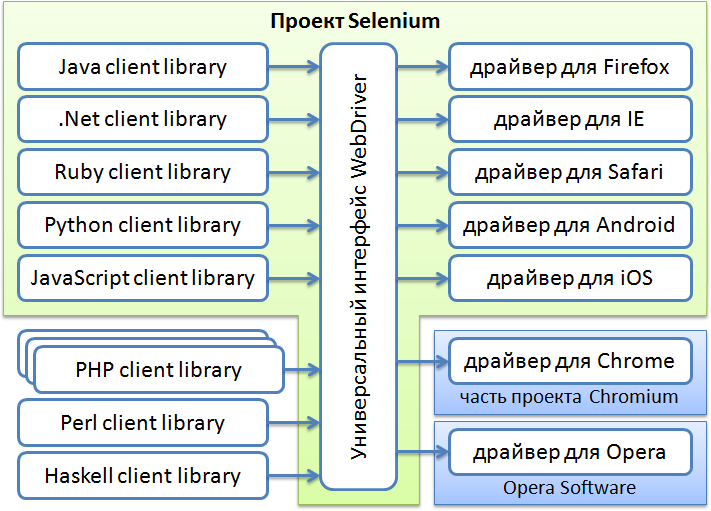

Для начала нужно инциализировать дравер браузера

ChromeDriver можно скачать [тут](https://chromedriver.chromium.org/)

Если путь до драйвера не прописан в PATH, его необходимо указать явно

Для запуска в колабе надо сделать несколько лишних действий, так как тут нет браузера и возможности запускать его с GUI

In [5]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300

UsageError: Cell magic `%%shell` not found.


In [6]:
!apt-get update
!apt-get install chromium chromium-driver

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get


In [7]:
options = Options()
options.add_argument("--window-size=1920,1080")
options.add_argument("--disable-extensions")
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument('--start-maximized')
options.add_argument('disable-blink-features=AutomationControlled')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36')
selenium_driver = webdriver.Chrome("chromedriver", options=options)

В случае использования не в колабе все сильно проще - примерно как [тут](https://habr.com/ru/company/otus/blog/596071/)

Снова попробуем спарсить Хабр

In [8]:
%%time

links = []
for page in tqdm(range(1, 21)):
    url = f"https://habr.com/ru/all/page{page}" # Парсим 20 страниц материалов
    selenium_driver.get(url)
    temp_links = selenium_driver.find_elements(By.CLASS_NAME, "tm-article-comments-counter-link__link")
    links.extend([link.get_property('href') for link in temp_links])

100%|██████████| 20/20 [01:21<00:00,  4.07s/it]

CPU times: user 526 ms, sys: 66 ms, total: 592 ms
Wall time: 1min 21s


In [9]:
links[:10]

['https://habr.com/ru/post/721158/comments/',
 'https://habr.com/ru/post/721156/comments/',
 'https://habr.com/ru/post/721154/comments/',
 'https://habr.com/ru/post/721152/comments/',
 'https://habr.com/ru/post/721152/comments/',
 'https://habr.com/ru/post/718862/comments/',
 'https://habr.com/ru/post/721146/comments/',
 'https://habr.com/ru/post/721146/comments/',
 'https://habr.com/ru/company/ispmanager/blog/721144/comments/',
 'https://habr.com/ru/post/721128/comments/']

In [10]:
@dataclass
class HabrArticle:
    text: str
    title: str
    votes: int

In [11]:
%%time

# Определим xpath для нужных нам элементов статьи
title_xpath = "//h1[@class='tm-article-snippet__title tm-article-snippet__title_h1'][1]/span"
text_xpath = "//div[@id='post-content-body']"
votes_xpath = "//span[contains(@class, 'tm-votes-meter__value')][1]"

articles = []


for link in tqdm(links[:20]):
    selenium_driver.get(link.replace('/comments', ''))
    title = selenium_driver.find_element(By.XPATH, title_xpath).get_attribute('innerText')
    text = selenium_driver.find_element(By.XPATH, text_xpath).get_attribute('innerText')
    votes = selenium_driver.find_element(By.XPATH, votes_xpath).get_attribute('innerText')
    
    item = HabrArticle(
        text=text,
        votes=int(votes.strip('+')),
        title=title,
    )
    articles.append(item)

100%|██████████| 20/20 [00:42<00:00,  2.12s/it]

CPU times: user 138 ms, sys: 72.2 ms, total: 210 ms
Wall time: 42.5 s


In [12]:
pd.set_option('display.max_colwidth', 400)

In [13]:
data = pd.DataFrame(articles)
data.head()

,text,title,votes
0,"В данной статье рассмотрим основные моменты при создании расширения google chrome для записи экрана и камеры. Оно может записывать целый экран, отдельное окно или вкладку. В режиме записи экрана можно вставлять окно с фронтальной камерой внутрь страницы на которой активен плагин, либо вне браузера. Также можно включить запись микрофона или звук системы. Ну и дополнительно можно осуществлять за...",Создаём расширение google chrome для записи экрана и камеры,2
1,"Всем привет! Меня зовут Иван и я QA Lead. Ниже, хочу поделиться своим первым и *спойлер* классным опытом публичного выступления на митапе.\n\nНемного о себе. В тестировании уже 9 лет, прошел путь от позиции Junior до Team Lead. Тестировал как десктоп, так и веб приложения. Фронт, бэк, автоматизация на Python. Довольно всесторонний опыт и хороший кругозор в индустрии. За последние год-два непло...",Выступать впервые не так страшно. История подготовки к IT-meetup,-2
2,"Подбор гиперпараметров модели – одна из самых распространенных задач в data science. Если заранее неизвестно, какими могут быть оптимальные значения, приходится искать по сетке значений. Если у нас есть m гиперпараметров и для каждого задано n возможных значений, то число вариантов равно mn и для каждого нужно обучить модель и определить ее точность. Если мы используем перекрестную проверку (c...",HalvingSearch: ускорение поиска по сетке (grid search). Библиотека sklearn,0
3,"2 марта крупнейший американский крипто банк Silvergate сообщил о задержке с публикацией годового финансового отчета, а затем и вовсе заявил о своей “возможной несостоятельности” по причине резкого снижения уровня капитализации. После этого, как и следовало ожидать, все партнеры стали поочередно отказываться от работы с банком, что сразу же создало дополнительное давление на капиталлизацию Silv...",История краха банка Silvergate и как он повлияет на криптоиндустрию. Кто следующий?,0
4,"2 марта крупнейший американский крипто банк Silvergate сообщил о задержке с публикацией годового финансового отчета, а затем и вовсе заявил о своей “возможной несостоятельности” по причине резкого снижения уровня капитализации. После этого, как и следовало ожидать, все партнеры стали поочередно отказываться от работы с банком, что сразу же создало дополнительное давление на капиталлизацию Silv...",История краха банка Silvergate и как он повлияет на криптоиндустрию. Кто следующий?,0


В таком режиме selenium работает медленнее, чем другие инстурменты для парсинга, и не особо отличается по функционалу. 

Его потенциал раскрывается в случаях, когда необходимо провести какое-то нетривиальное взаимодействие со страницей - клик, скролл, заполнение поля в форме и тп

Примеры такой реализации в виде нормального python-проекта - coming soon :)